# SERIES TEMPORALES: MODELOS PREDICTIVOS
## Facebook's NEURAL Prophet

`v2.2`
---


NEURALPROPHET

https://neuralprophet.com/contents.html

NeuralProphet se diseñó en 2020, y cierra la brecha entre los modelos tradicionales de series temporales y los métodos de aprendizaje profundo. Es una implementación de PyTorch basada en redes neuronales, que, al incorporar algo de aprendizaje profundo autorregresivo, debería tener un rendimiento igual o mejor que Prophet, ya que se ajustan a datos autorregresivos.

Neural está diseñado en una arquitectura completamente modular que lo hace escalable para así poder añadir componentes adicionales. Al igual que Prophet, es una herramienta fácil de usar y de interpretar para los usuarios tanto expertos como no expertos.  

Adicionalmente, NeuralProphet permite construir modelos de pronóstico para escenarios donde hay otros factores externos que se pueden ser usar para impulsar el comportamiento de la serie objetivo a lo largo del tiempo. Esto hace mejorar a los modelos de predicción debido a no depender únicamente de la autocorrelación de las series temporales.

NeuralProphet se descompone en componentes, tendencia, estacionalidad, autorregresión, eventos especiales, regresores futuros y regresores retrasados.  
Los futuros son variables externas que tienen valores futuros conocidos para el período de pronóstico, mientras que los rezagados solo tienen valores para el período observado.

Por su parte, la tendencia se puede modelar como una tendencia lineal o por tramos mediante el uso de puntos de cambio. La estacionalidad se modela empleando términos de Fourier y, por lo tanto, puede manejar múltiples estacionalidades para datos de alta frecuencia. Por último, la regresión automática se maneja mediante una implementación de AR-Net, una red neuronal de retroalimentación automática regresiva para series temporales.

El modelo NeuralProphet se puede representar como:


Donde:  
•	T(t) = es la tendencia  
•	S(t) = es el efecto estacional  
•	E(t) = es el efecto de vacaciones y eventos  
•	F(t) = es el efecto de regresión en el momento t para variables exógenas conocidas en el futuro  
•	A(t) = es el efecto de autorregresión  
•	L(t) = es el efecto de regresión en el momento t para observaciones más amplias de las variables exógenas.


In [ ]:
#
import os, sys
from google.colab import drive
drive.mount('/content/mnt', force_remount=True)
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks/Librerias', nb_path)
#sys.path.insert(0, nb_path)  # or append(nb_path)
sys.path.append(nb_path)  # or append(nb_path)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#!pip install --target=$nb_path torch==1.12.1

In [4]:
#pip install --target=$nb_path neuralprophet

In [5]:
#!pip install git+https://github.com/ourownstory/neural_prophet.git numpy==1.23.5 torch

# Ejemplo Ventas de coches

## Bibliotecas y Configuracion

In [6]:
#pip install --target=$nb_path install ephem

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralprophet import NeuralProphet

from sklearn.metrics import mean_absolute_error

In [8]:
from neuralprophet import set_random_seed
set_random_seed(0)

In [9]:
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style({'font.family': 'serif','fontname': 'Times New Roman'})

In [10]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  if np.any(y_true==0)==True:
    print('Erro: y_true contêm zeros!')
    return np.inf
  else:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Importar y visualizar datos

In [11]:
# load data
path = '/content/mnt/My Drive/Colab Notebooks/Series Temporales/S11/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

df.columns = ['ds', 'y']
df['ds']=pd.to_datetime(df['ds'])

print(df.head(2))
print(df.tail(2))
print()
df.info()

          ds     y
0 1960-01-01  6550
1 1960-02-01  8728
            ds      y
106 1968-11-01  17180
107 1968-12-01  14577

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      108 non-null    datetime64[ns]
 1   y       108 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.8 KB


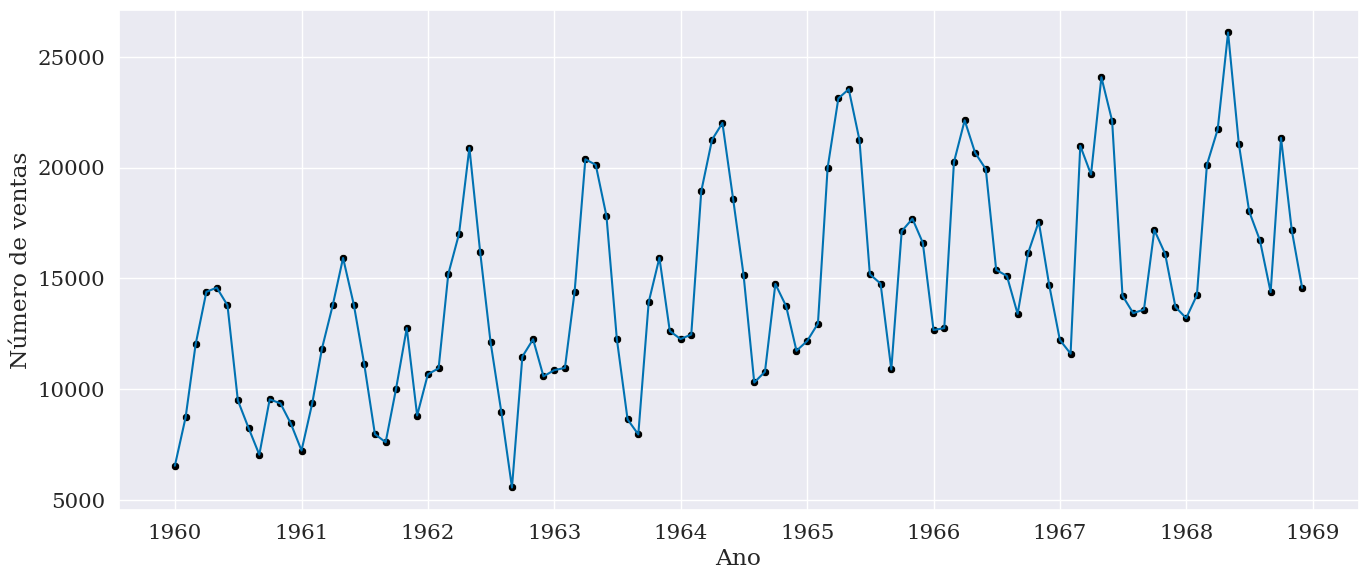

In [12]:
#df.plot(figsize=(10,5), style='.-'); plt.show()

plt.figure(figsize=(16,6.5))
Xlabel='Ano'; Ylabel='Número de ventas'

sns.scatterplot(data=df, x='ds', y='y', color='black')
sns.lineplot(data=df, x='ds', y='y', linewidth=1.5, color='#0072B2', label='')

#plt.legend(loc='lower right')
plt.xlabel(Xlabel)
plt.ylabel(Ylabel)
plt.show()

## Modelo de predicción: train-test

In [13]:
#Separar datos en train y test
N=12; Freq='MS'
train = df.drop(df.index[-N:])
test  = df.loc[df.index[-N:]]

print(train.shape, test.shape)
print(train.tail(1),'\n',test.head(1))

(96, 2) (12, 2)
           ds      y
95 1967-12-01  13713 
            ds      y
96 1968-01-01  13210


## Modelo de predicción: definir Neural-Prophet

class neuralprophet.forecaster.NeuralProphet(growth='linear', changepoints=None, n_changepoints=10, changepoints_range=0.8, trend_reg=0, trend_reg_threshold=False, trend_global_local='global', yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', seasonality_mode='additive', seasonality_reg=0, season_global_local='global', n_forecasts=1, n_lags=0, num_hidden_layers=0, d_hidden=None, ar_reg=None, learning_rate=None, epochs=None, batch_size=None, loss_func='Huber', optimizer='AdamW', newer_samples_weight=2, newer_samples_start=0.0, quantiles=None, impute_missing=True, impute_linear=10, impute_rolling=10, drop_missing=False, collect_metrics=True, normalize='auto', global_normalization=False, global_time_normalization=True, unknown_data_normalization=False)

In [14]:
%%time
#model = NeuralProphet()

model = NeuralProphet(
    growth="linear",    # Determine trend types: 'linear', 'discontinuous', 'off'
    changepoints=None,  # list of dates that may include change points (None->automatic)
    n_changepoints=15,
    changepoints_range=0.8,
    trend_reg=0,
    trend_reg_threshold=False,
    yearly_seasonality="auto",
    weekly_seasonality="auto",
    daily_seasonality="auto",
    seasonality_mode="additive",
    seasonality_reg=0,
    n_forecasts=1,
    n_lags=0, # modeificar
    epochs=50, #  50
    loss_func="Huber",
    normalize="auto",   # Type of normalization ('minmax', 'standardize', 'soft', 'off')
    impute_missing=True
)

CPU times: user 1 ms, sys: 1e+03 ns, total: 1.01 ms
Wall time: 6.34 ms


## Modelo de predicción: Estimar

In [15]:
metrics = model.fit(train, freq=Freq)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.958]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [98.958]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO:NP.utils:Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with

Finding best initial lr:   0%|          | 0/207 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

## Modelo de predicción: Predicción

In [16]:
future = model.make_future_dataframe(train, periods=len(test), n_historic_predictions=len(train))
forecast = model.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [98.958]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [98.958]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.074]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [99.074]% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO:NP.df_utils:Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to [99.074]% of the data.
INFO:NP.df_utils:Major frequency MS corresponds to [99.074]% of the data.
INFO - (NP.df_utils._infer_frequency) 

Predicting: 3it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column


In [17]:
forecast

,ds,y,yhat1,trend,season_yearly
0,1960-01-01,6550,3835.730713,6729.446289,-2893.715576
1,1960-02-01,8728,3956.818604,6926.998535,-2970.179932
2,1960-03-01,12026,10232.458984,7111.805664,3120.653320
3,1960-04-01,14395,12658.824219,7309.357910,5349.466797
4,1960-05-01,14587,13605.755859,7500.537598,6105.218262
...,...,...,...,...,...
103,1968-08-01,None,13515.062500,16531.597656,-3016.534424
104,1968-09-01,None,11736.269531,16507.492188,-4771.223145
105,1968-10-01,None,16175.299805,16484.162109,-308.862457
106,1968-11-01,None,16107.308594,16460.058594,-352.749146


## Resultados

In [18]:
model.plot(forecast)

WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 


##  Evaluación y error

In [19]:
y_true = test['y'].values
y_pred = forecast['yhat1'][-12:].values
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'MAE:  {mae:.2f} ventas')
print(f'MAPE: {mape:.2f}%')

MAE:  1751.62 ventas
MAPE: 9.45%


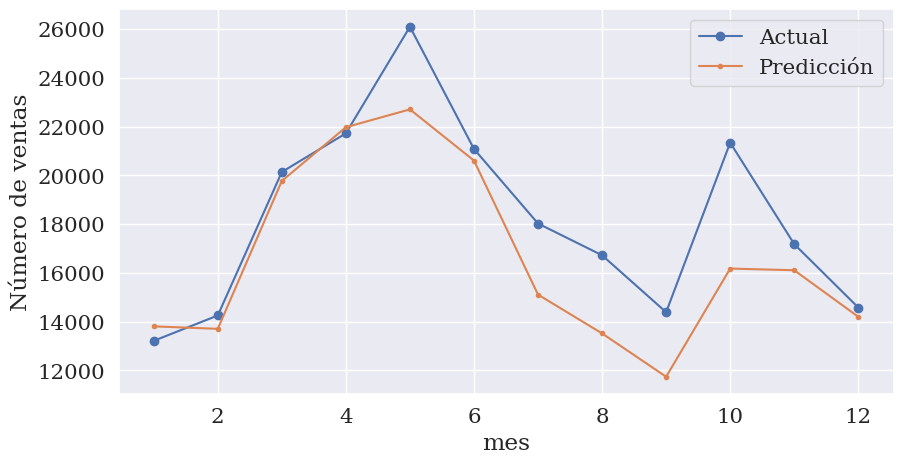

In [20]:
# plot expected vs actual
plt.figure(figsize=(10,5))
x=np.arange(1,len(y_true)+1,1)
plt.plot(x,y_true,'o-', label='Actual')
plt.plot(x,y_pred,'.-', label='Predicción')

plt.ylabel(Ylabel)
plt.xlabel('mes')
plt.legend()
plt.show()

_________________
_________________

In [21]:
metrics

,MAE,RMSE,Loss,RegLoss,epoch
0,11089.403320,12756.933594,0.400412,0.0,0
1,10833.557617,12508.122070,0.388717,0.0,1
2,10542.598633,12192.085938,0.375581,0.0,2
3,10164.241211,11807.430664,0.358747,0.0,3
4,9699.683594,11330.116211,0.337652,0.0,4
5,9080.463867,10680.361328,0.309731,0.0,5
6,8355.151367,9887.240234,0.277022,0.0,6
7,7407.692871,8980.995117,0.236516,0.0,7
8,6401.494629,7883.974609,0.194564,0.0,8
9,5391.740723,6726.273438,0.152856,0.0,9


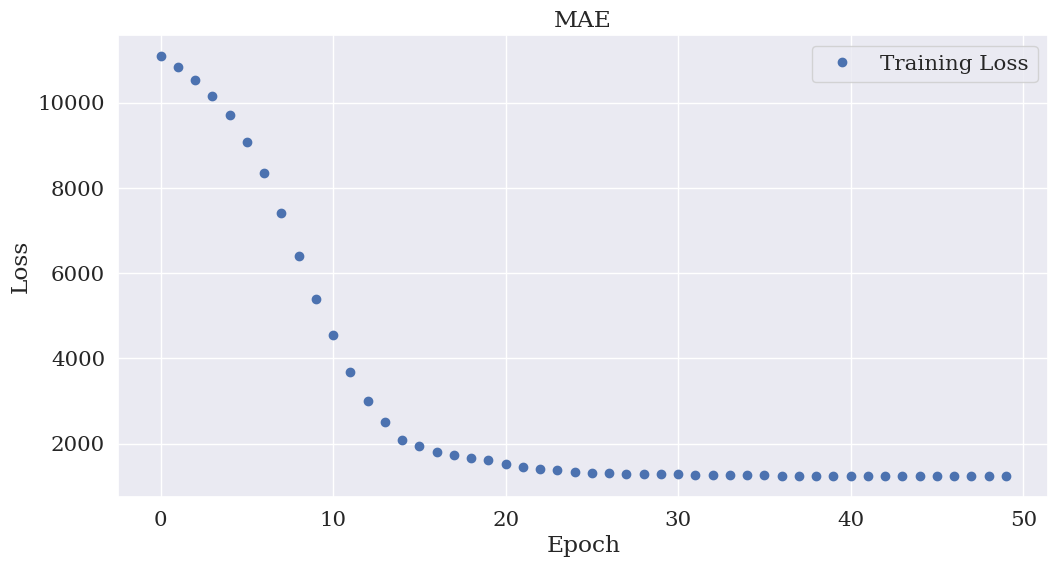

In [22]:
plt.subplots(figsize=(12, 6))
plt.plot(metrics['MAE'], 'ob', linewidth=6, label="Training Loss")
#plt.plot(metrics['MAE_val'], '-r', linewidth=2, label="Validation Loss")
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html

## Componentes de la predicción:


In [28]:
model.plot_parameters()


WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 


In [29]:
model.plot_components(forecast)


WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 


_________________
_________________